In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from RoadAlignment import Road_Alignment

In [3]:
def plot_fitness_performance_per_run(run_num, avg_fitness_per_run, best_fitness_per_run):
        plt.figure()
        plt.plot(range(1, run_num + 1), avg_fitness_per_run, label='Average Fitness', color='blue')
        plt.plot(range(1, run_num + 1), best_fitness_per_run, label='best Fitness', color='green')
        plt.xlabel('Run')
        plt.ylabel('Fitness')
        plt.title('Per Run')
        plt.legend()
        plt.show()

In [4]:
data = np.load('map.npy')
num_run = 7

In [5]:
def road_alignment(run_num,data, pop_size, max_generations, tournament_size, crossover_probability, uniform_crossover_probability, 
                 mutation_probability, uniform_mutation_probability, boltzmann_selection_temperature, elite_percentage, convergence_threshold, no_improvement_threshold, type_crossover, type_mutation, type_parent_selection):
    avg_fitness_per_run = []
    best_fitness_per_run = []
    min_fitness_per_run = []
    for i in range(0,run_num):
        print("---------------------------------")
        print("this run number: ",i+1)
        ra = Road_Alignment(data, pop_size, max_generations, tournament_size, crossover_probability, uniform_crossover_probability, 
                 mutation_probability, uniform_mutation_probability, boltzmann_selection_temperature, elite_percentage, convergence_threshold, no_improvement_threshold, type_crossover, type_mutation, type_parent_selection)
        last_generation, average_fitness_values, best_fitness_values = ra.genetic_algorithm()
        
        avg_fitness_per_run.append(np.mean(average_fitness_values))
        best_fitness_per_run.append(np.mean(best_fitness_values))
        
        ra.visulaize_solution()
        ra.plot_fitness_performance(last_generation, average_fitness_values, best_fitness_values)
        
    plot_fitness_performance_per_run(run_num, avg_fitness_per_run, best_fitness_per_run)

#### uniform crossover, uniform mutation, tournament parent_selection

---------------------------------
this run number:  1
83.0


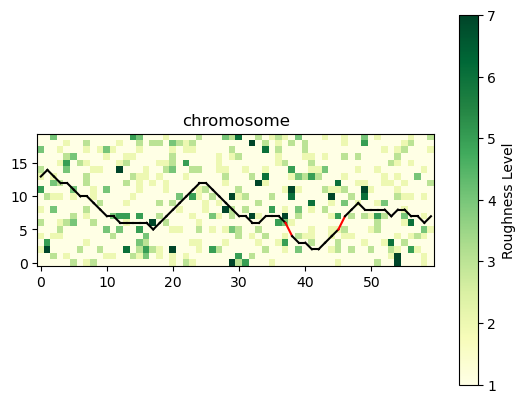

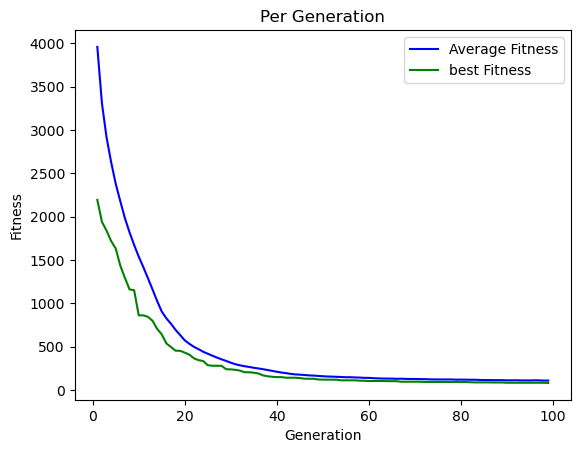

---------------------------------
this run number:  2
71.0


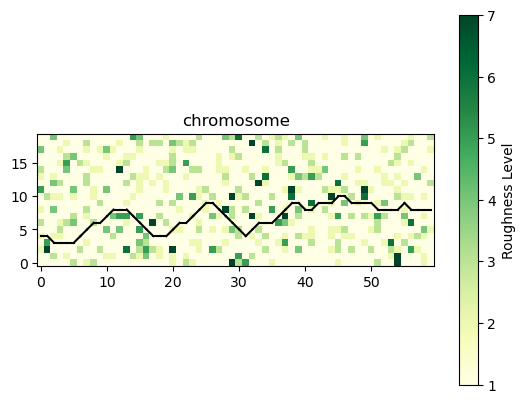

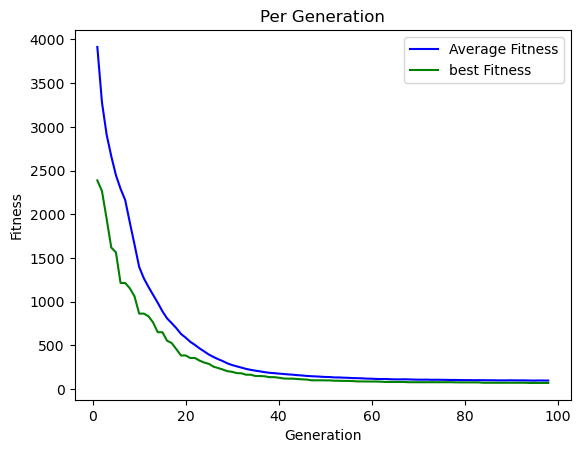

---------------------------------
this run number:  3
64.0


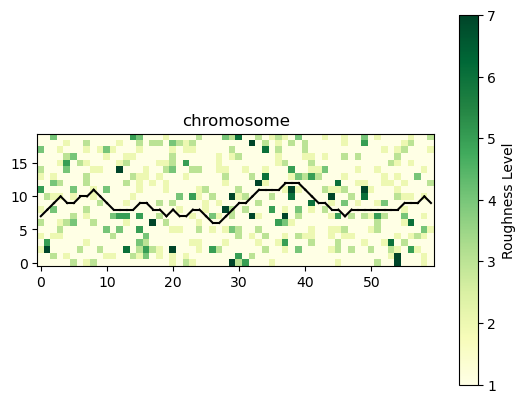

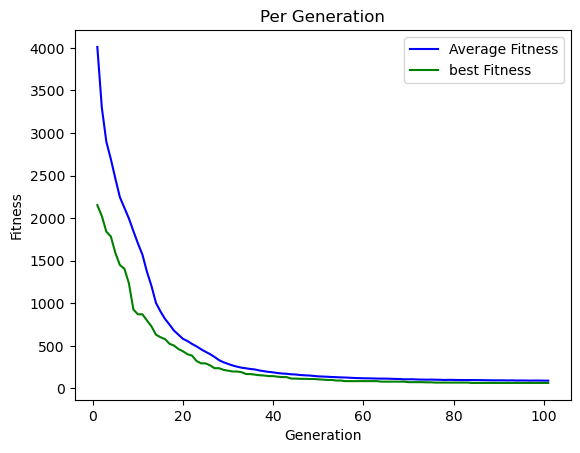

---------------------------------
this run number:  4
76.0


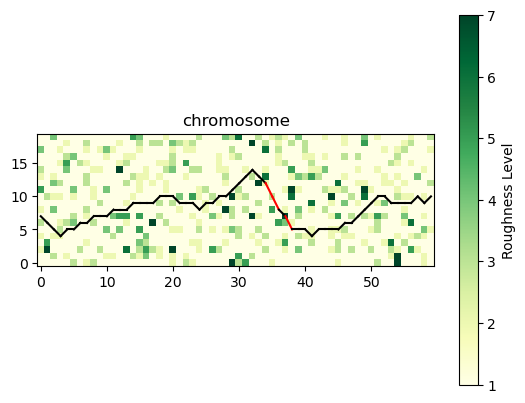

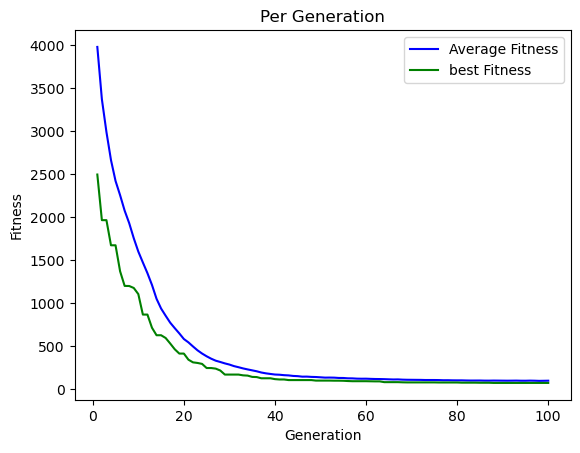

---------------------------------
this run number:  5
70.0


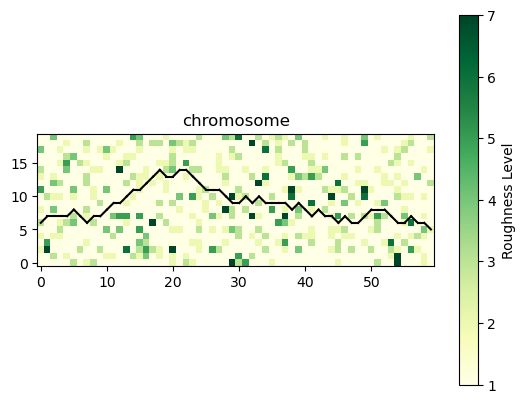

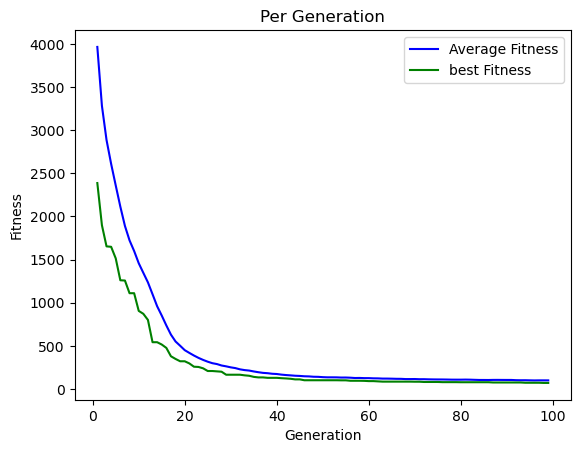

---------------------------------
this run number:  6
80.0


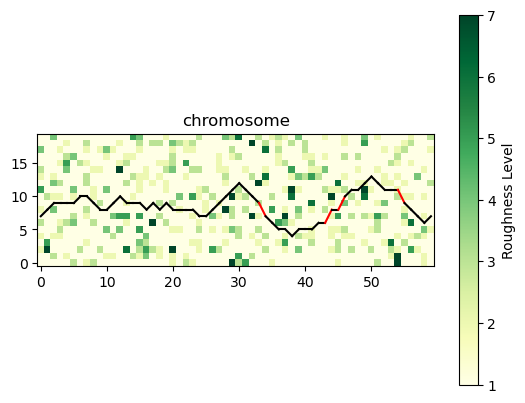

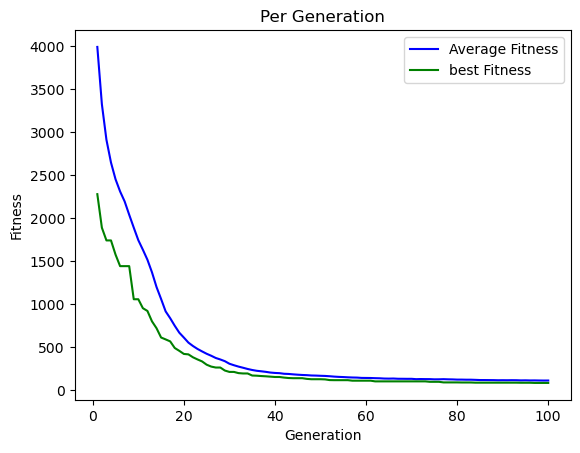

---------------------------------
this run number:  7
74.0


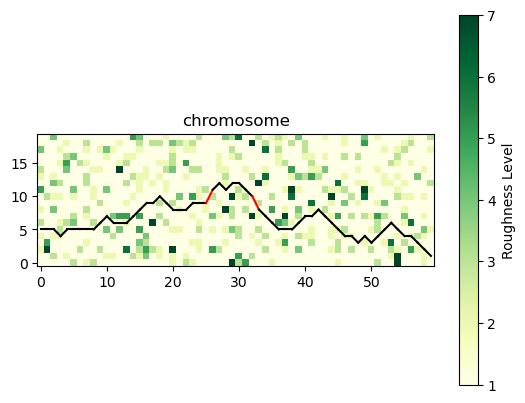

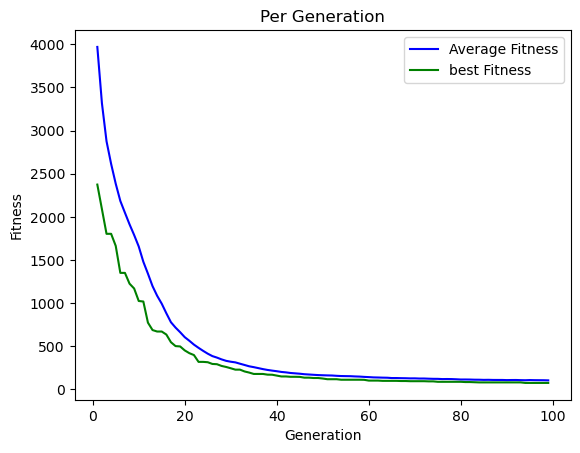

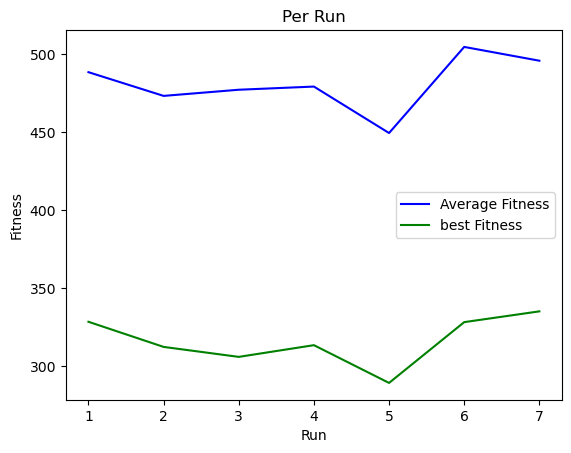

In [5]:
road_alignment(num_run,data, pop_size=350, max_generations=130, tournament_size=5, crossover_probability=0.8, uniform_crossover_probability=0.6, 
                 mutation_probability=1, uniform_mutation_probability=0.1, boltzmann_selection_temperature=1, elite_percentage=0.2, convergence_threshold=4e-1, no_improvement_threshold=10, type_crossover="uniform", type_mutation="uniform", type_parent_selection="tournament")

### arithmetic crossover - uniform mutation - tournament parent_selection

why starting point is the same??? local optimum
since arithmetic crossover is more exploiting elite percentage is set to 0.05

---------------------------------
this run number:  1
66.0


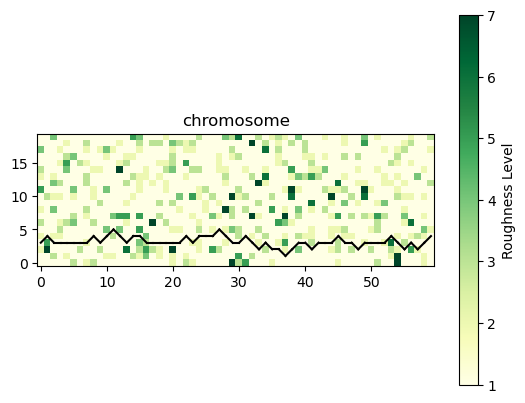

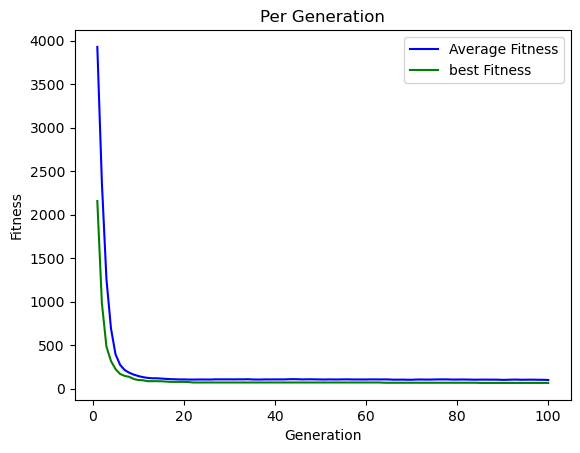

---------------------------------
this run number:  2
69.0


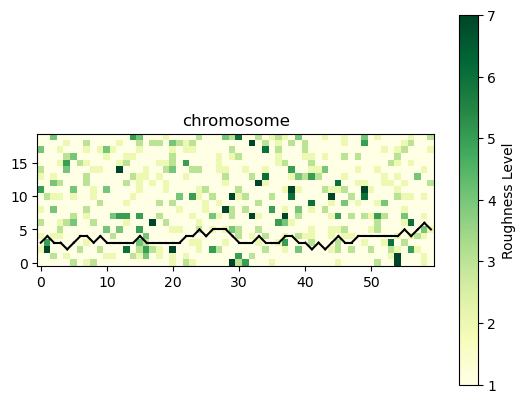

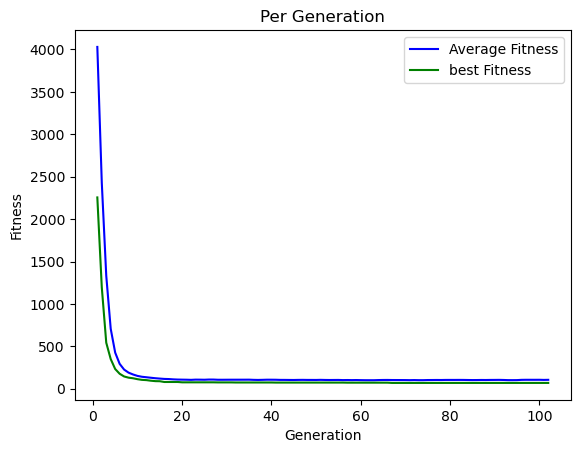

---------------------------------
this run number:  3
67.0


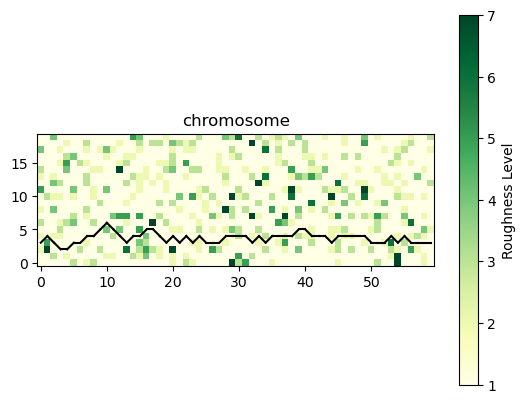

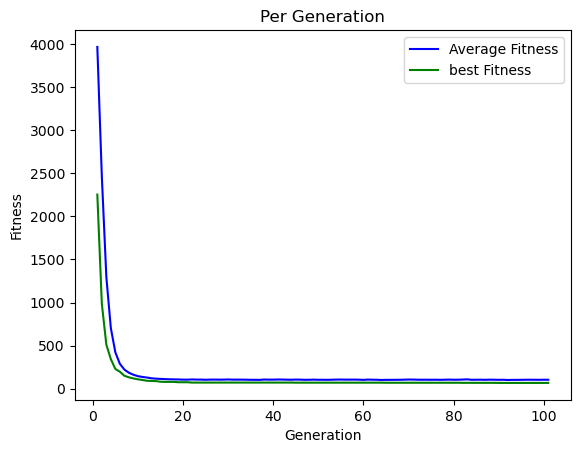

---------------------------------
this run number:  4
67.0


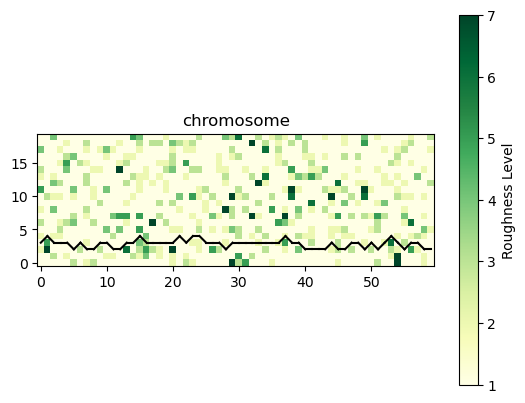

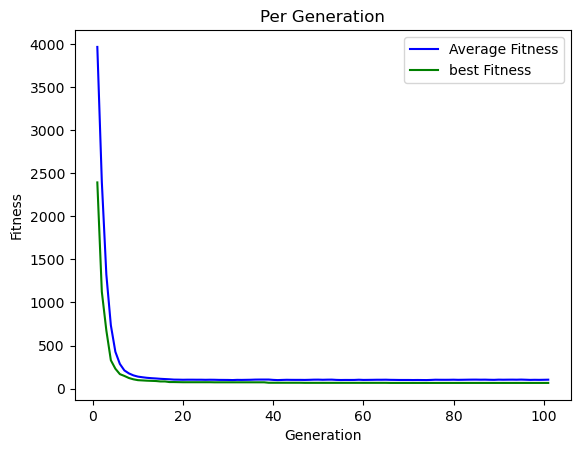

---------------------------------
this run number:  5
62.0


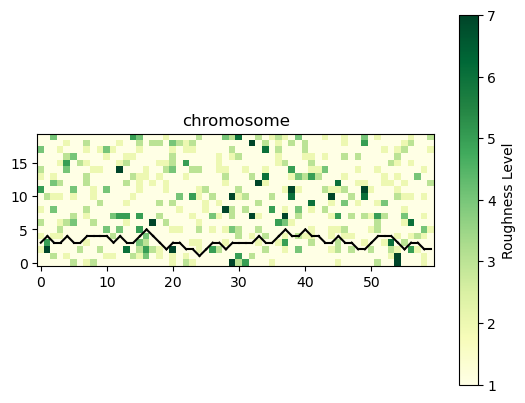

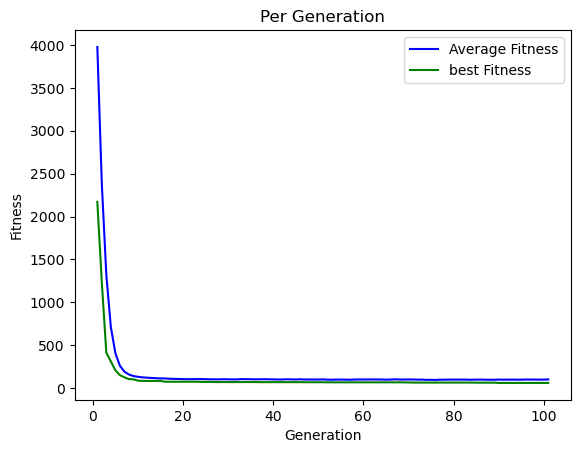

---------------------------------
this run number:  6
63.0


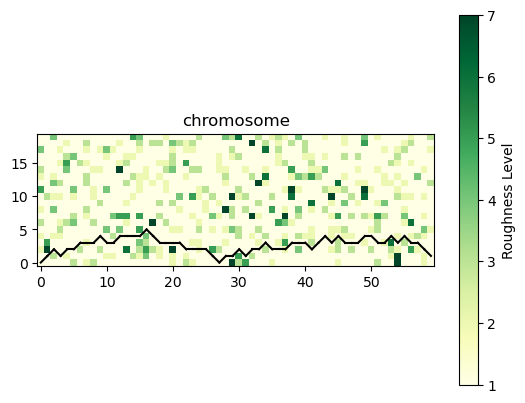

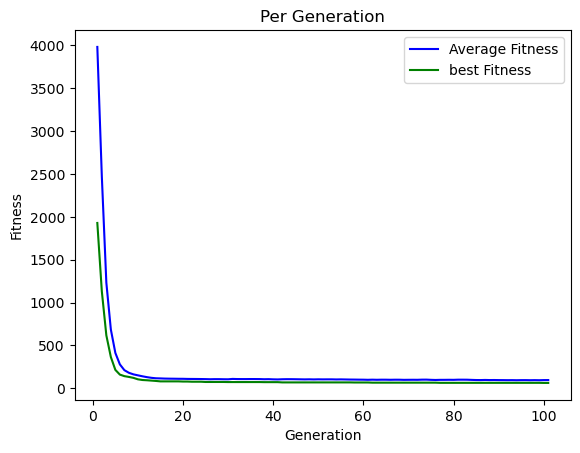

---------------------------------
this run number:  7
69.0


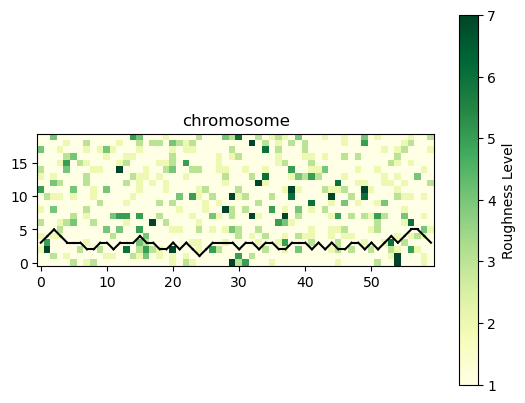

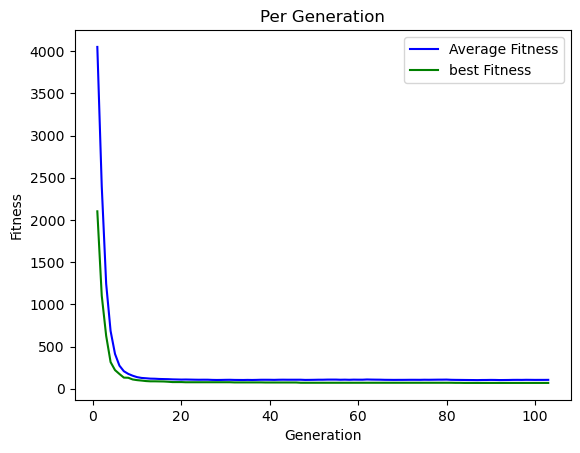

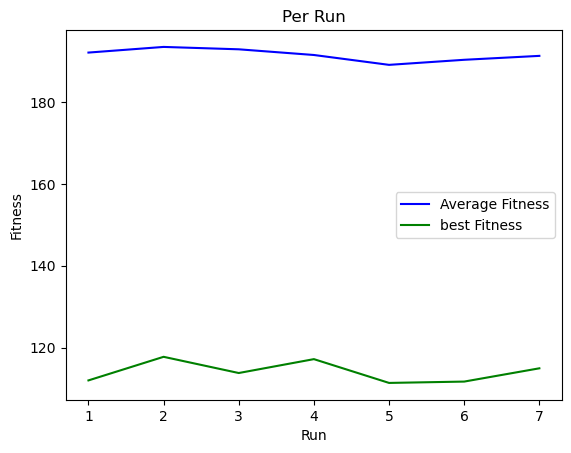

In [10]:
road_alignment(num_run, data, pop_size=350, max_generations=130, tournament_size=5, crossover_probability=0.8, uniform_crossover_probability=0.6, 
                 mutation_probability=1, uniform_mutation_probability=0.1, boltzmann_selection_temperature=1, elite_percentage=0.05, convergence_threshold=4e-1, no_improvement_threshold=10, type_crossover="arithmetic", type_mutation="uniform", type_parent_selection="tournament")

### one-point crossover - uniform mutation - tournament

---------------------------------
this run number:  1
84.0


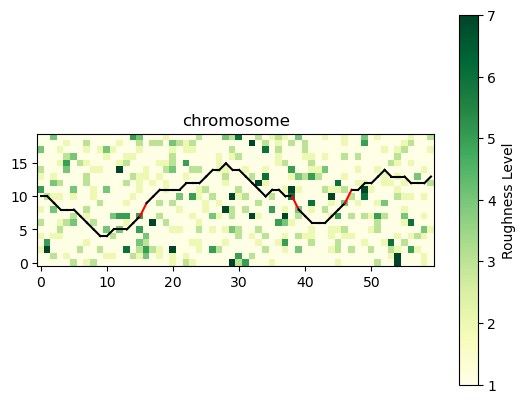

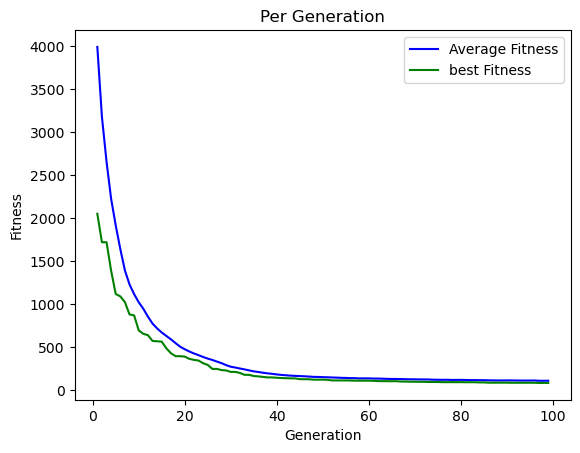

---------------------------------
this run number:  2
71.0


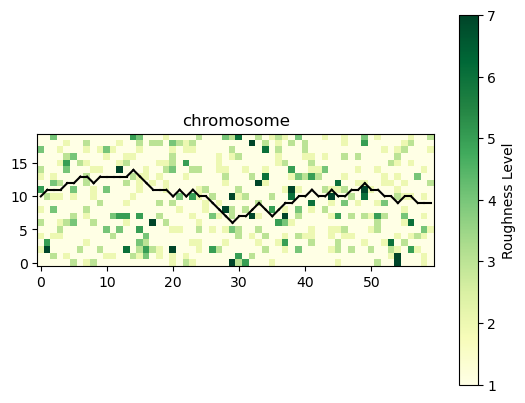

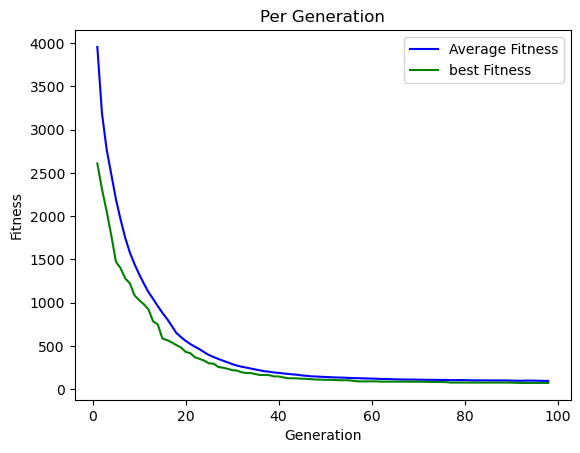

---------------------------------
this run number:  3
87.0


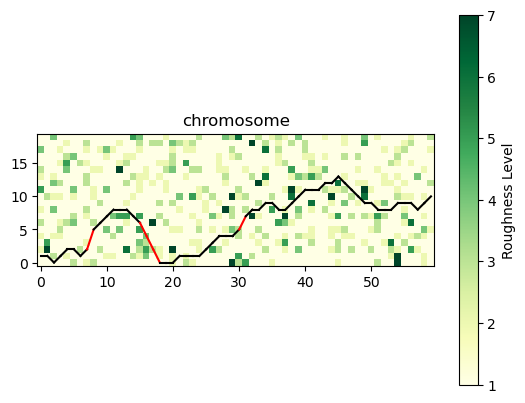

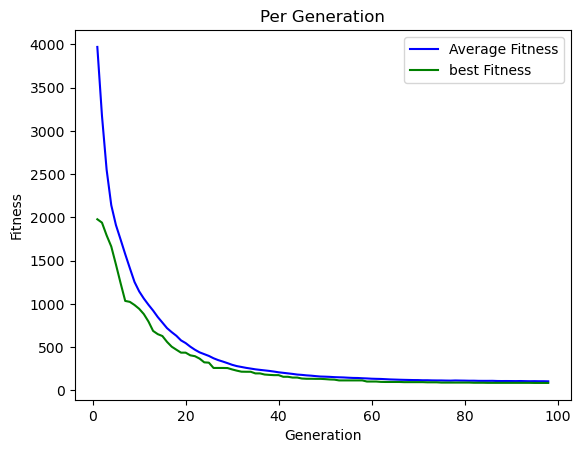

---------------------------------
this run number:  4
96.0


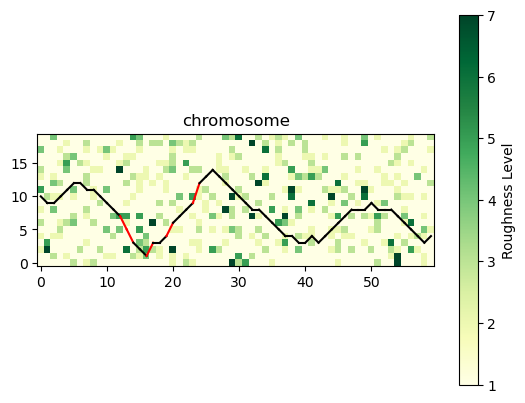

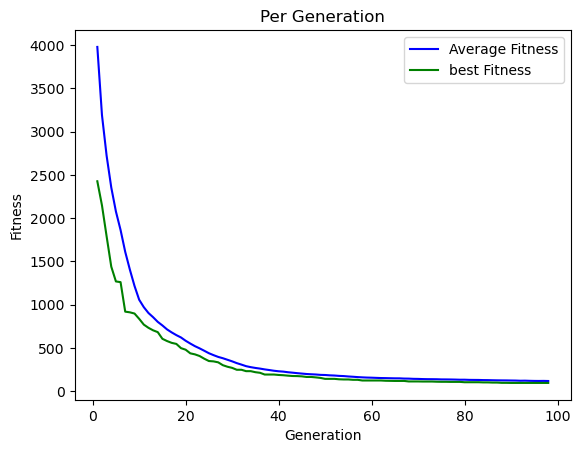

---------------------------------
this run number:  5
92.0


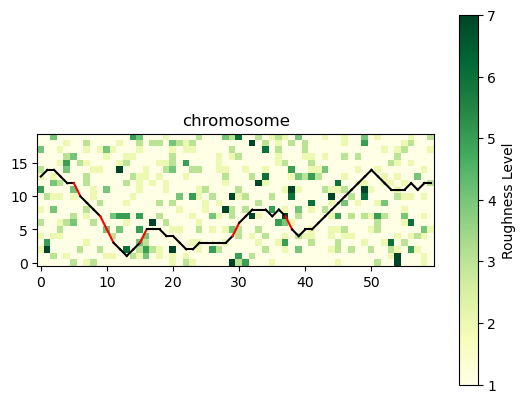

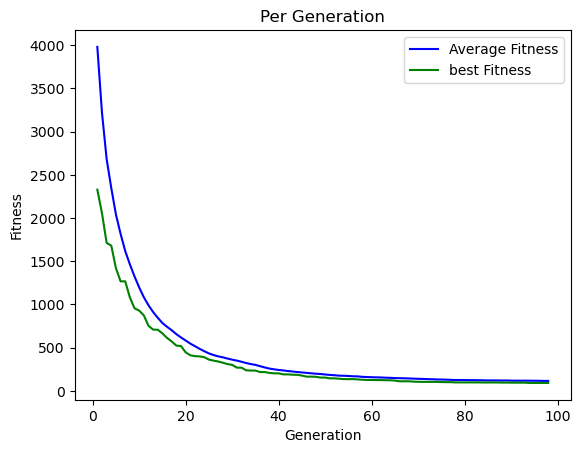

---------------------------------
this run number:  6
86.0


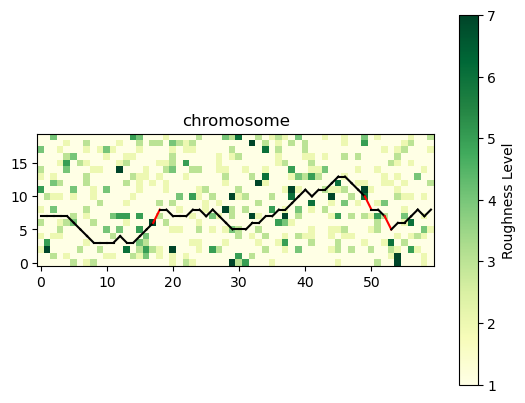

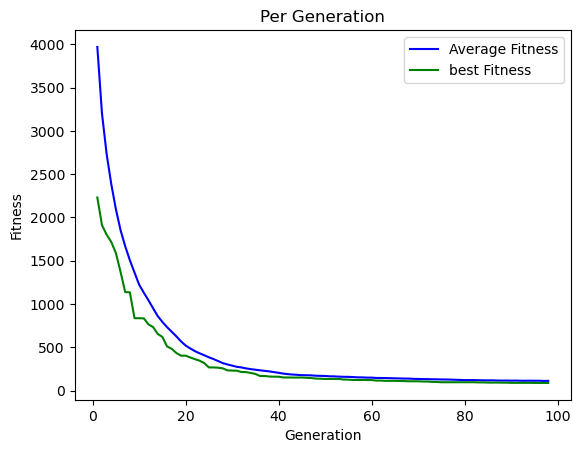

---------------------------------
this run number:  7
74.0


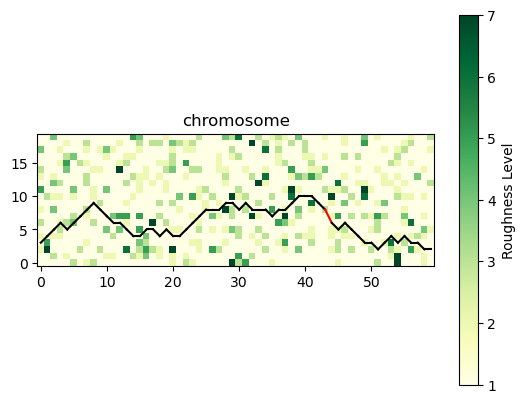

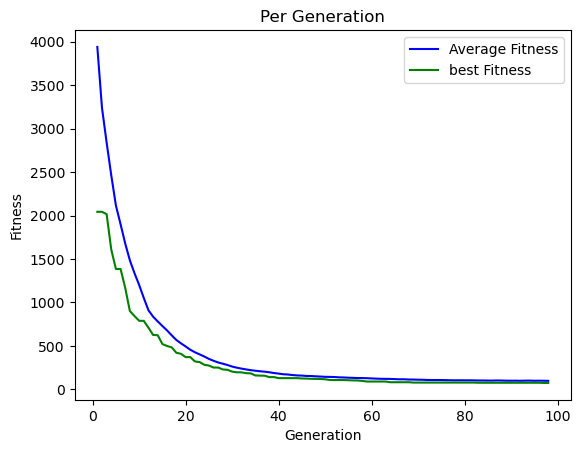

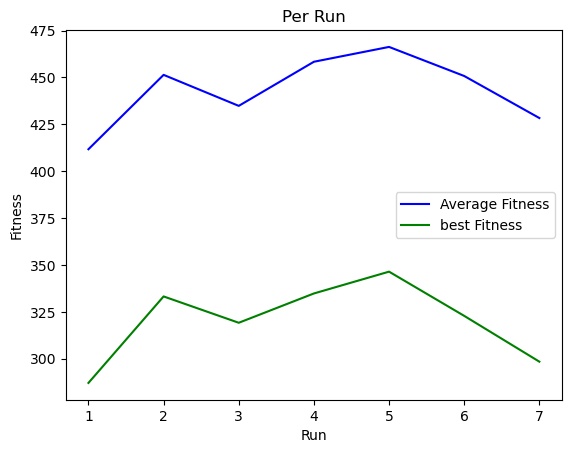

In [5]:
road_alignment(num_run, data, pop_size=350, max_generations=130, tournament_size=5, crossover_probability=0.8, uniform_crossover_probability=0.6, 
                 mutation_probability=1, uniform_mutation_probability=0.1, boltzmann_selection_temperature=1, elite_percentage=0.2, convergence_threshold=4e-1, no_improvement_threshold=10, type_crossover="one-point", type_mutation="uniform", type_parent_selection="tournament")

### arithmetic crossover - inversion mutation - tournament

---------------------------------
this run number:  1
65.0


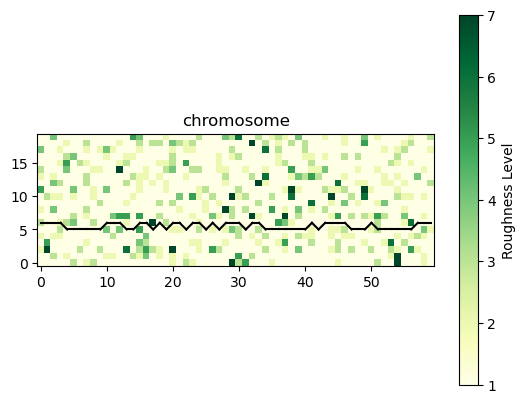

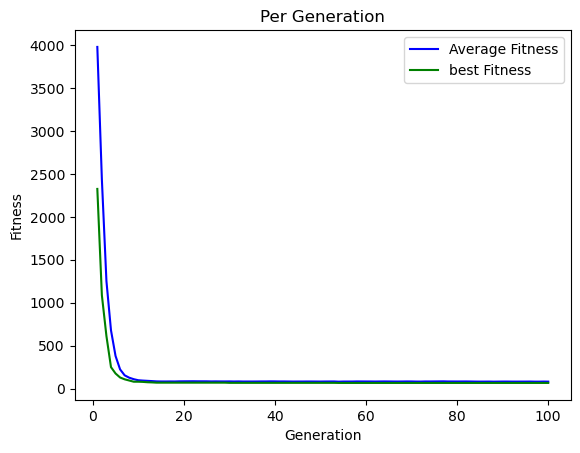

---------------------------------
this run number:  2
66.0


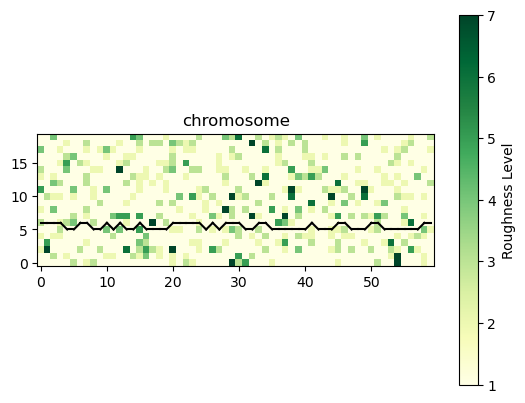

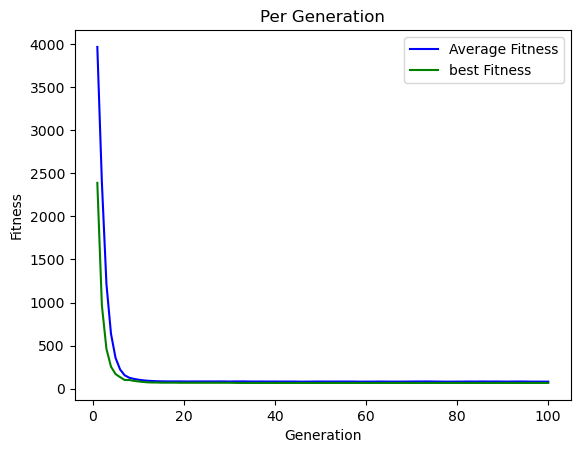

---------------------------------
this run number:  3
63.0


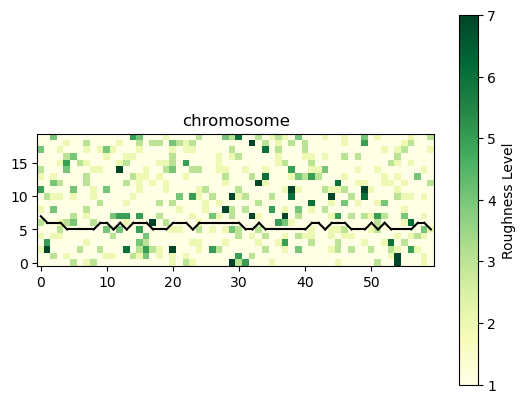

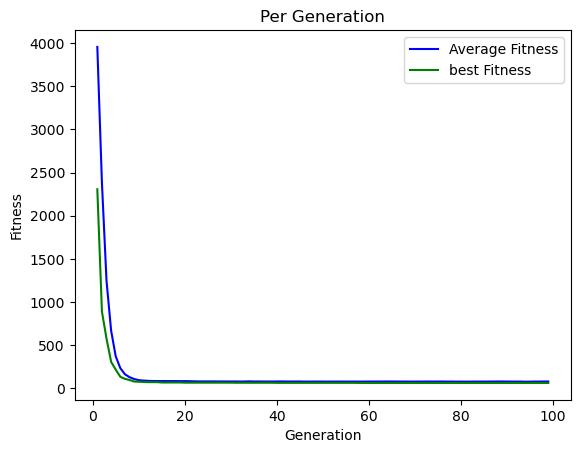

---------------------------------
this run number:  4
65.0


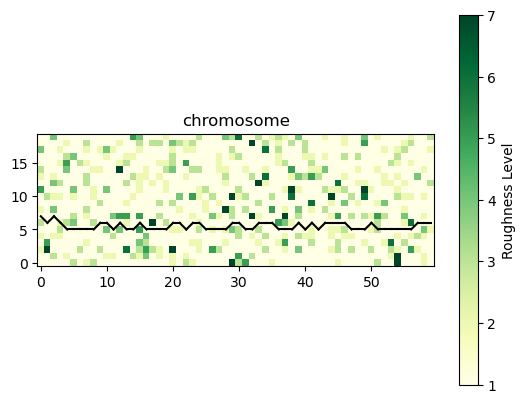

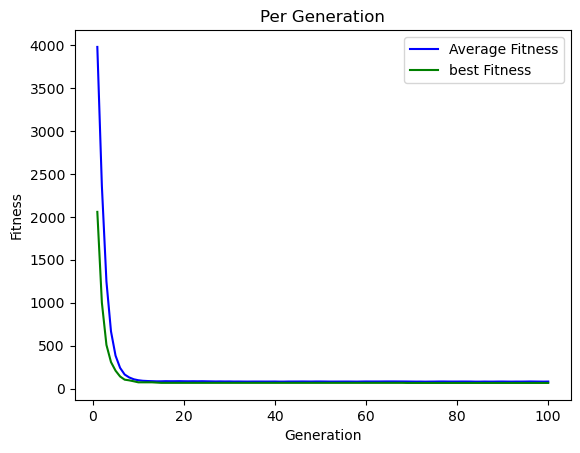

---------------------------------
this run number:  5
63.0


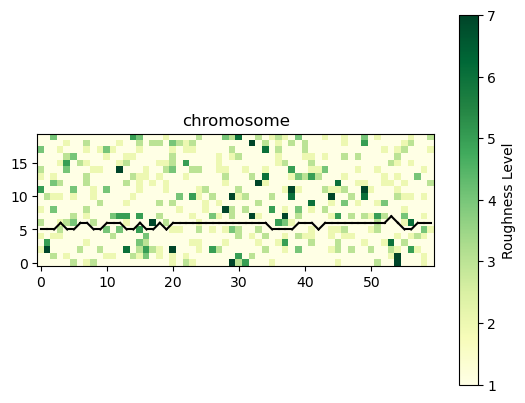

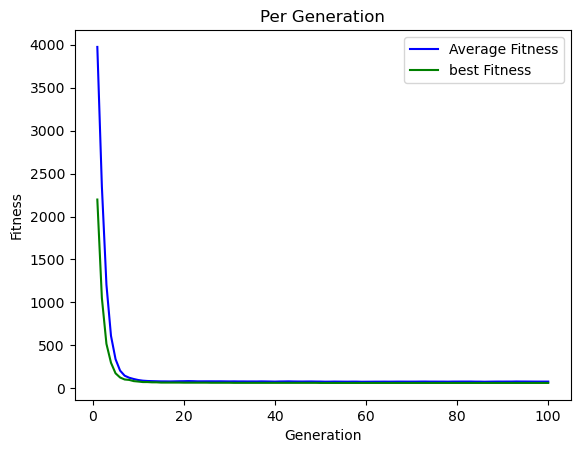

---------------------------------
this run number:  6
65.0


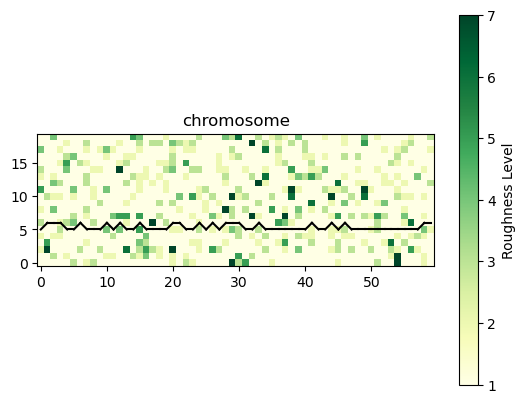

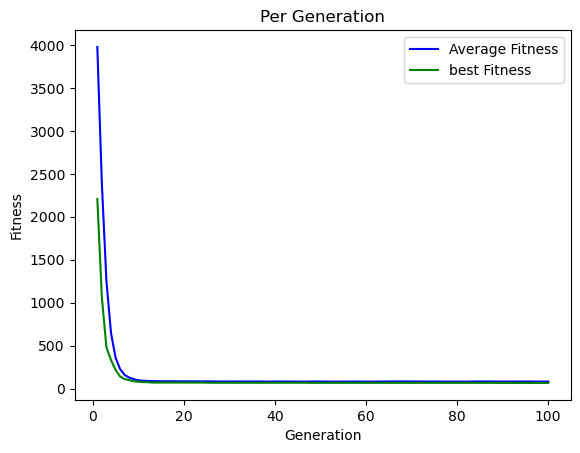

---------------------------------
this run number:  7
66.0


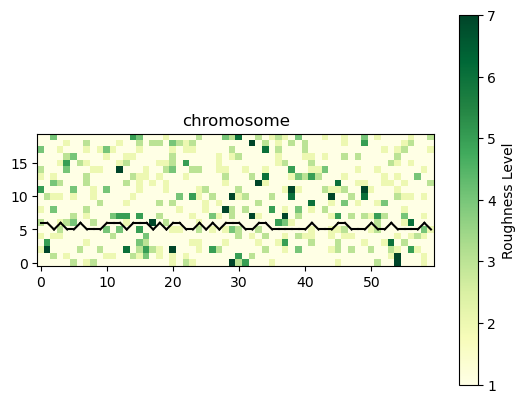

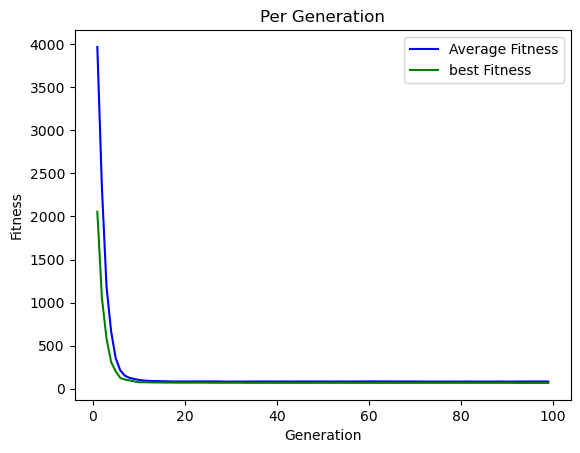

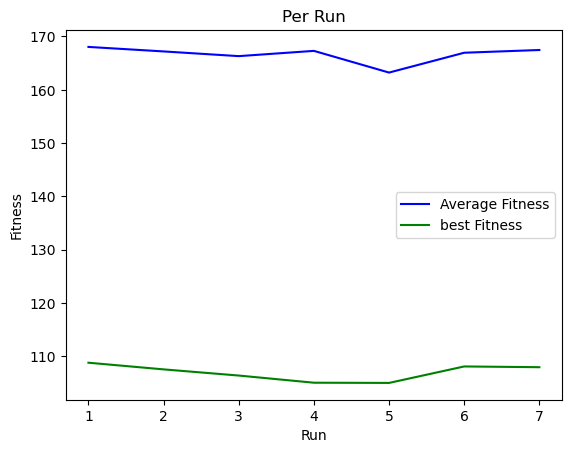

In [6]:
road_alignment(num_run, data, pop_size=350, max_generations=130, tournament_size=5, crossover_probability=0.8, uniform_crossover_probability=0.6, 
                 mutation_probability=1, uniform_mutation_probability=0.1, boltzmann_selection_temperature=1, elite_percentage=0.05, convergence_threshold=4e-1, no_improvement_threshold=10, type_crossover="arithmetic", type_mutation="inversion", type_parent_selection="tournament")

#### (30 - 75 map) arithmetic crossover - inversion mutation - tournament

In [6]:
def create_road_map(size, probabilities):
    levels = len(probabilities)
    map_values = np.zeros(size, dtype=int)
    flat_map = map_values.flatten()
    for i in range(len(flat_map)):
        flat_map[i] = np.random.choice(levels, p=probabilities)+1
    road_map = flat_map.reshape(size)
    return road_map

In [9]:
map_size = (30, 75)
roughness_probabilities = [0.7, 0.15, 0.09, 0.02, 0.02, 0.01, 0.01]
road_map = create_road_map(map_size, roughness_probabilities)

---------------------------------
this run number:  1
89.0


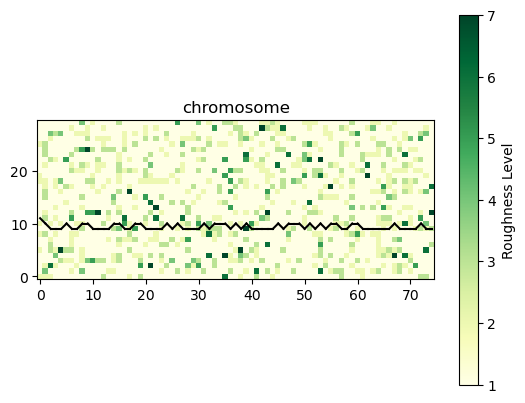

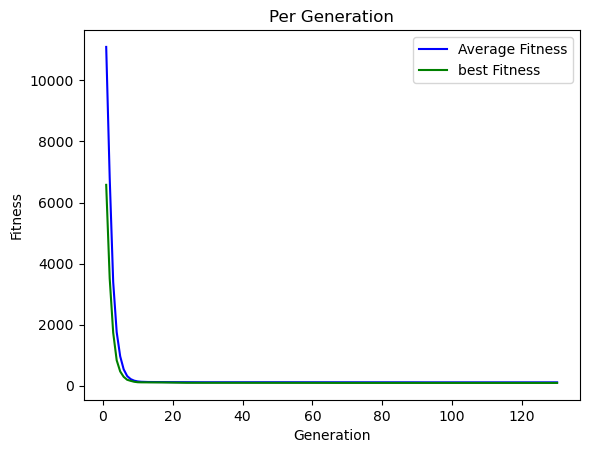

---------------------------------
this run number:  2
86.0


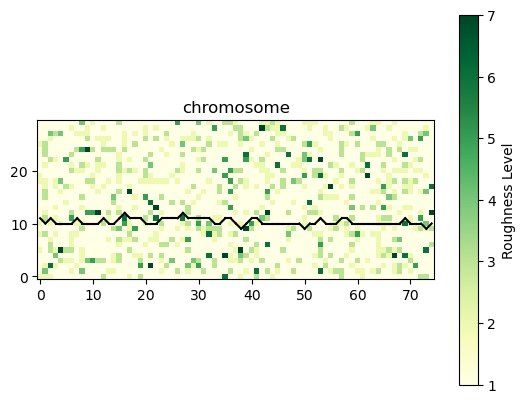

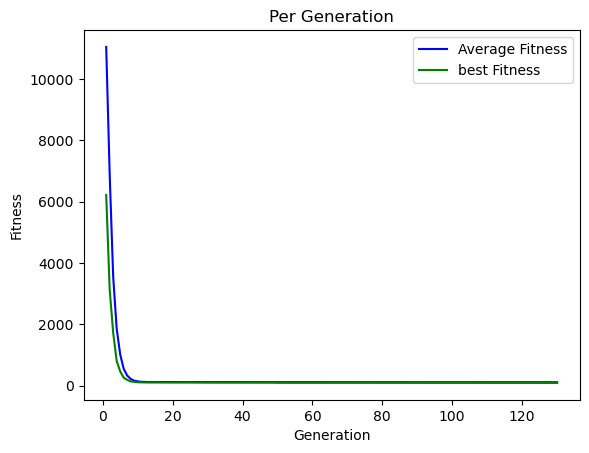

---------------------------------
this run number:  3
94.0


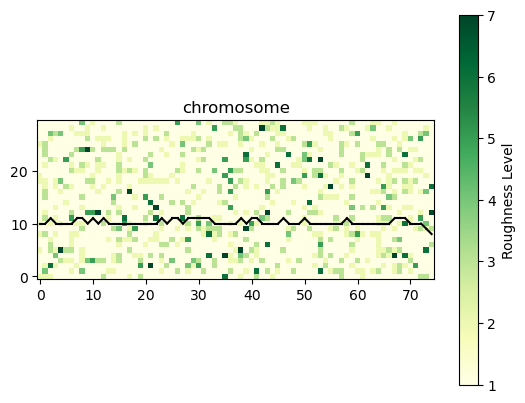

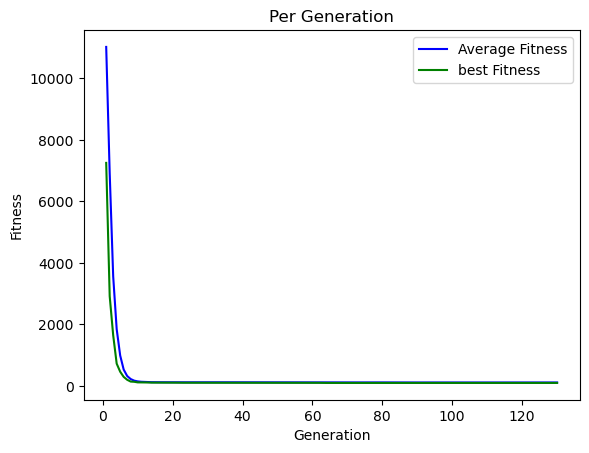

---------------------------------
this run number:  4
93.0


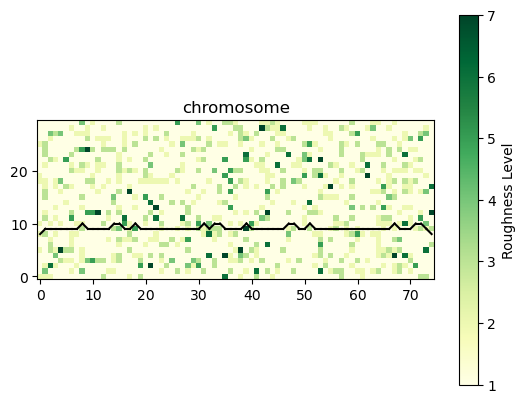

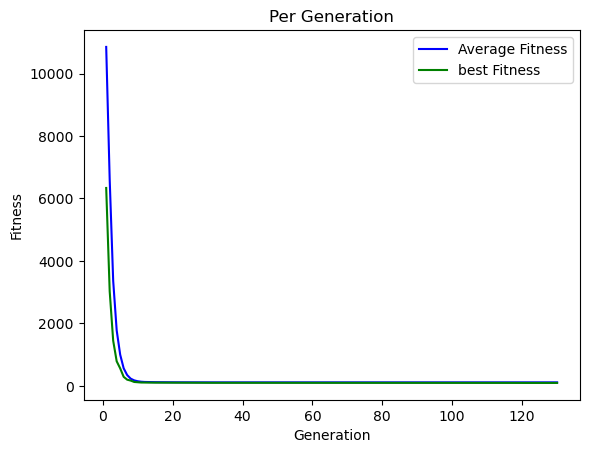

---------------------------------
this run number:  5
88.0


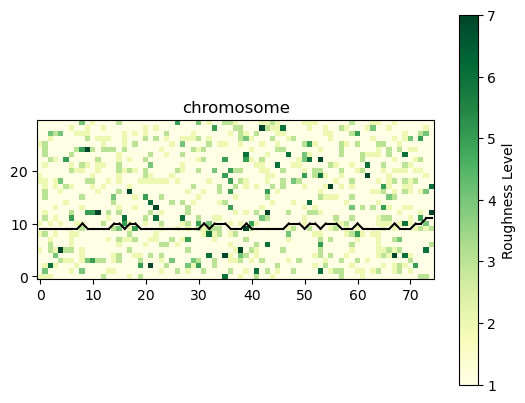

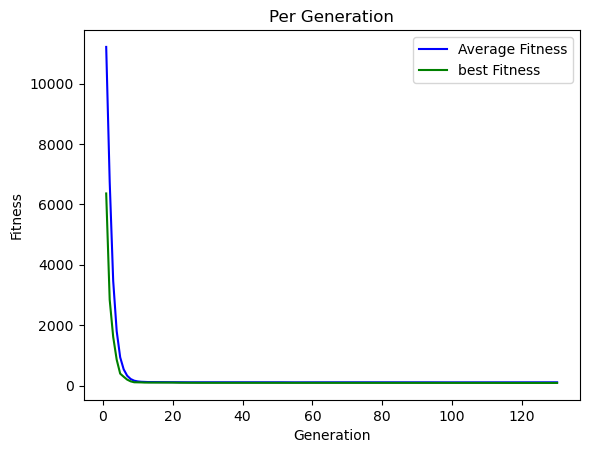

---------------------------------
this run number:  6
86.0


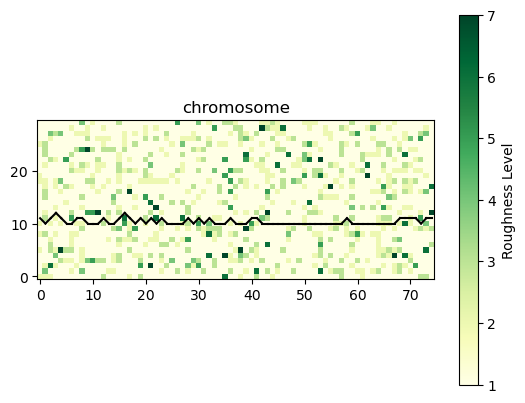

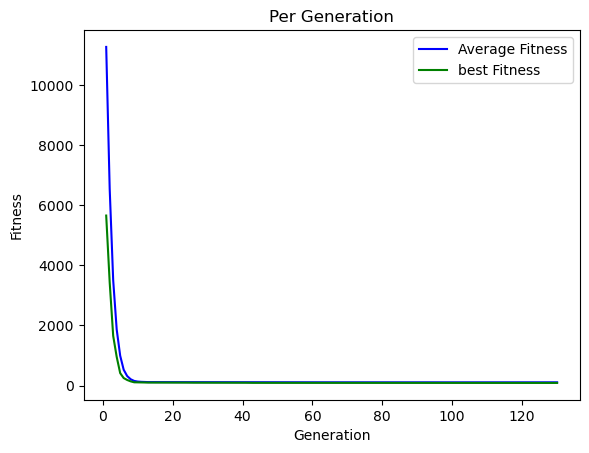

---------------------------------
this run number:  7
91.0


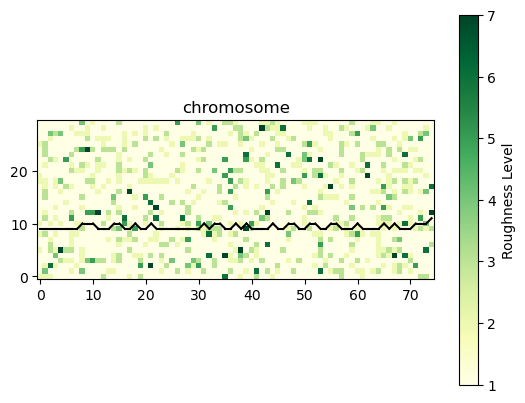

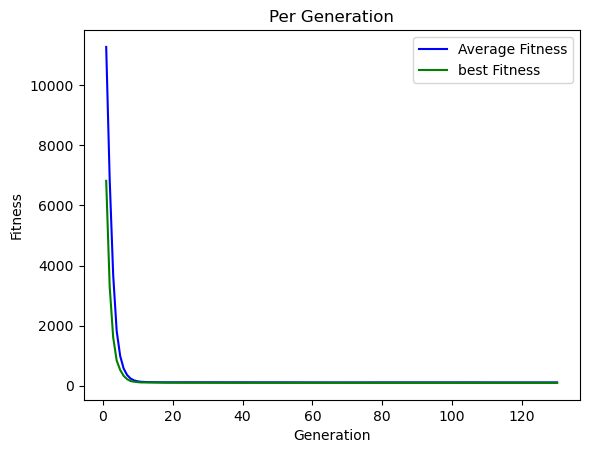

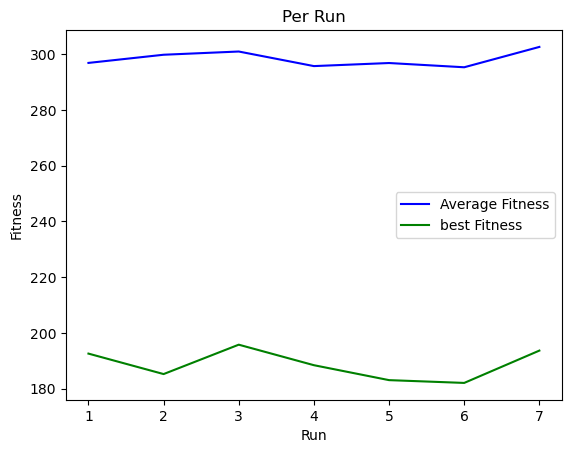

In [10]:
road_alignment(7, road_map, pop_size=350, max_generations=130, tournament_size=5, crossover_probability=0.8, uniform_crossover_probability=0.6, 
                 mutation_probability=1, uniform_mutation_probability=0.1, boltzmann_selection_temperature=1, elite_percentage=0.05, convergence_threshold=4e-1, no_improvement_threshold=10, type_crossover="arithmetic", type_mutation="inversion", type_parent_selection="tournament")